In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [22]:
data = pd.read_csv(r'C:\Users\vmadmin\Documents\ML App\Pokemon.csv')


In [23]:
#DATA TRANSFORMATION PIPELINE 
#sequentially apply transformers then an estimator

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline


numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')), ('encoder', OrdinalEncoder())])



In [24]:
#pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ???? kmeans)])

In [25]:
from sklearn.preprocessing import StandardScaler
skills = ['HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']
scaler = StandardScaler()
fitted_scaler = scaler.fit_transform(data[skills])


In [26]:
from sklearn.cluster import KMeans

inertia = []
for cluster in range(1, 15):
    kmeans = KMeans(n_clusters=cluster, init="k-means++", random_state=49, n_init=100)
    kmeans.fit(fitted_scaler)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow Chart to Select K')

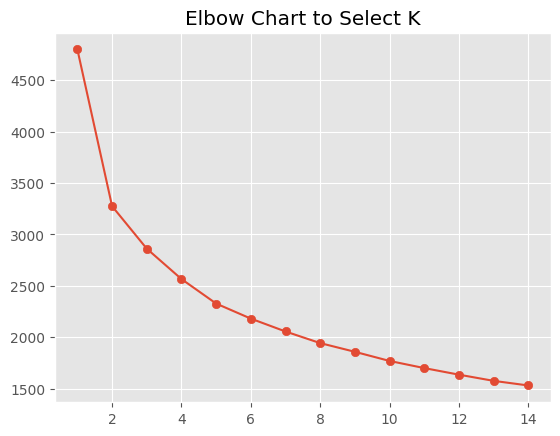

In [27]:
plt.plot(range(1,15), inertia)
plt.scatter(range(1,15), inertia)
plt.title('Elbow Chart to Select K')

In [28]:
# find clusters now using K selected based on chart above
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=49, n_init=100)
kmeans.fit(fitted_scaler)
data['cluster'] = kmeans.labels_

centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_))
centroids.columns = skills
centroids['cluster'] = [0, 1, 2, 3, 4]


In [29]:
#sns.pairplot(data[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', "cluster"]], palette="colorblind" ,hue = "cluster");

In [43]:

cluster_table = data.groupby(['cluster']).agg({
    'HP': 'median', 
    'Attack': 'median', 
    'Defense': 'median', 
    'Sp. Atk': 'median', 
    'Sp. Def': 'median', 
    'Speed': 'median'
})
print(cluster_table)
cluster_table.to_html('../templates/cluster_table.html', classes='table table-stripped')

            HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
cluster                                                 
0         90.0   120.0     90.0    120.0     96.0  100.0
1         50.0    53.0     50.0     45.0     49.5   50.0
2         65.0    87.0    115.0     60.0     85.5   50.0
3        100.0    90.5     77.0     75.0     80.0   55.0
4         68.0    80.0     65.0     80.0     70.0   91.0


In [31]:
#kmeans.cluster_centers_

In [32]:
data.to_csv("PokemonClustered.csv", index=False)
# diff = kmeans.cluster_centers_ - np.array(#new data)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data[skills], data['cluster'], test_size=0.2)

In [34]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


y_pred = knn.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
# initial accuracy is 92%, try to improve using cross validation

Accuracy:  0.90625


In [36]:
from sklearn.model_selection import cross_val_score


k_vals = [i for i in range (1, 30)]
scores=[]
X = scaler.fit_transform(data[skills])

for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, data['cluster'], cv=5)
    scores.append(np.mean(score))

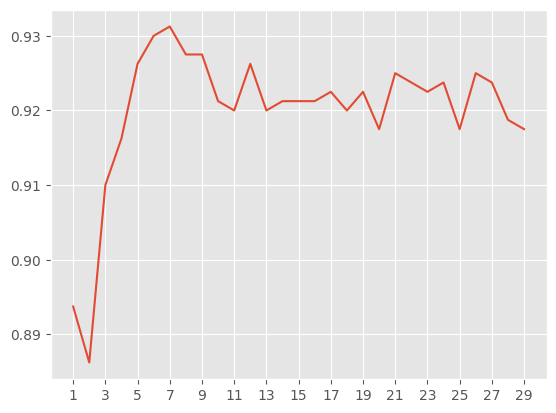

In [37]:
sns.lineplot(x=k_vals, y=scores).set_xticks(np.arange(1, 31, 2))
# best k value is 7

In [38]:
best_index = np.argmax(scores)
best_k = k_vals[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("accuracy: ", accuracy)
print("precision: ", precision) 
print("recall: ", recall)

accuracy:  0.93125
precision:  [1.         0.95081967 0.94117647 0.95652174 0.85365854]
recall:  [0.85714286 1.         0.8        0.91666667 0.94594595]


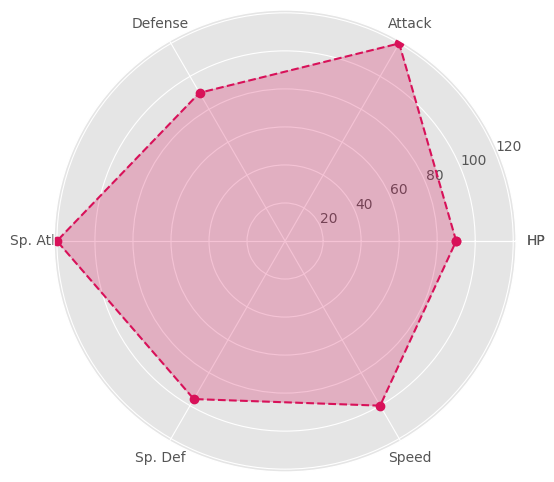

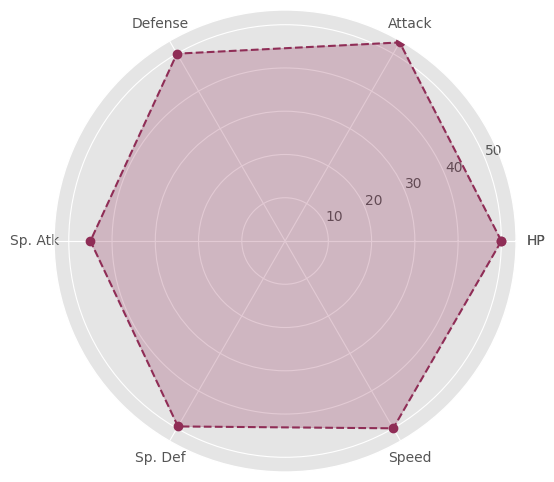

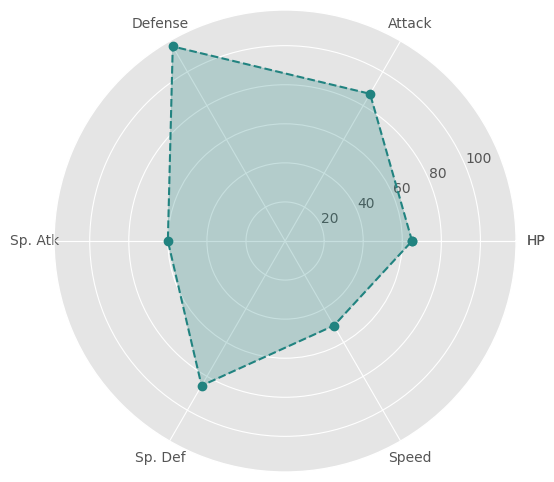

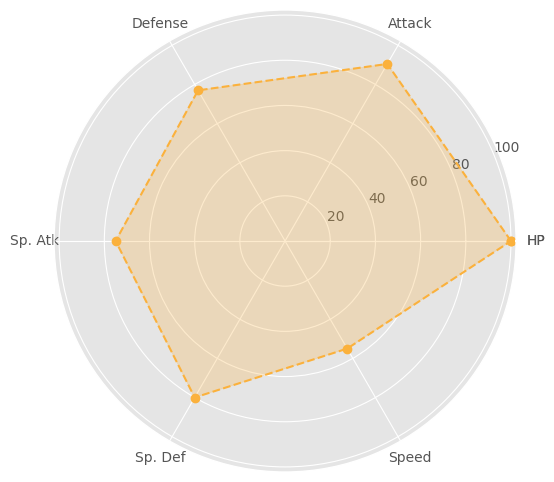

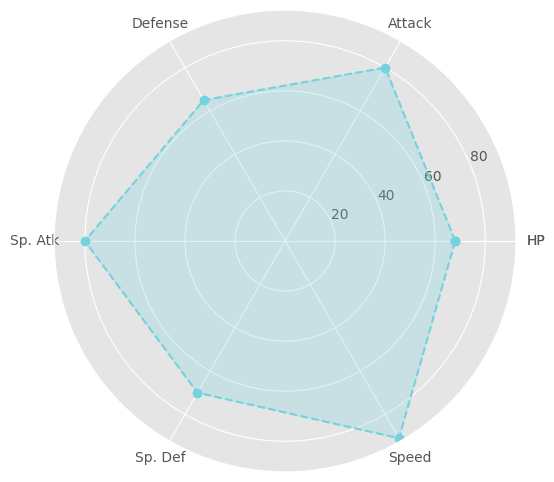

In [46]:
plt.style.use('ggplot')
angles = np.linspace(0, 2*np.pi, 6, endpoint = False)
angles = np.concatenate((angles, [angles[0]]))

# skills.append(skills[0])

color_sequence = ["#d81159", "#8f2d56", "#218380", "#fbb13c", "#73d2de"]

for index, row in cluster_table.iterrows():
    row = np.concatenate((row, [row[0]]))
    fig = plt.figure(figsize=(6,6))
    ax=fig.add_subplot(polar=True)
    ax.fill(angles, row, alpha=0.25, color=color_sequence[index])
    ax.plot(angles, row, 'o--', color=color_sequence[index], label="cluster "+str(index))
    ax.set_thetagrids(angles*180/np.pi, skills)
    plt.show()

In [40]:
pickle.dump(knn, open('classifier.pkl', 'wb'))